In [1]:
import numpy as np
import theano
import theano.tensor as T
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,scale
import math
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sklearn.datasets
%matplotlib inline

In [2]:
TRAINING_RATE = 0.5
TESTING_RATE = 1 - TRAINING_RATE
MISSING_RATE = 0.3
# QUERY_RATE = 0.2
np.random.seed(0)

In [3]:
data = pd.read_csv("../dat/wine_quality/winequality-white.csv",sep=';')

In [4]:
def preprocessing(d):
    #Add normalization code here if necessary
#     d.ix[:,0:-1] = scale(d.ix[:,0:-1])
    #0-1 scale
    min_max_scaler = MinMaxScaler()
    d.ix[:,0:-1] = min_max_scaler.fit_transform(d.ix[:,0:-1])
    d['quality'] = d['quality'].apply(lambda x: int(x) -3)
    d['fil'] = d['quality'].apply(lambda x:0 if x==0 or x==5 or x==6 else 1)
    d = d[d['fil']==1]
    d.drop('fil',axis=1,inplace=True)
    d['quality'] = d['quality'].apply(lambda x: 1 if x==3 or x == 4 else 0)
    d = d.iloc[np.random.permutation(len(d))]
    t = int(len(d) * TRAINING_RATE)
    tn_data = d.iloc[0:t,:]
    tt_data = d.iloc[t:,:]
    
    tn_X = tn_data.ix[:,0:-1]
    tn_Y = tn_data.ix[:,-1]
    tt_X = tt_data.ix[:,0:-1]
    tt_Y = tt_data.ix[:,-1]
    
    return tn_X,tn_Y, tt_X, tt_Y
#     return tt_X, tt_Y

In [5]:
tn_X,tn_Y,tt_X,tt_Y = preprocessing(data)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
def TestMissingGenerate(tt_data,mr=MISSING_RATE):
    missing_entry = []
    row , col= range(tt_data.shape[0]),range(tt_data.shape[1])
    
    while len(missing_entry) < tt_data.shape[0] * tt_data.shape[1] * mr:
        r = np.random.choice(row)
        c = np.random.choice(col)
        
        if (r,c) not  in missing_entry:
            missing_entry.append((r,c))
        else:
            continue
    
    for me in missing_entry:
        tt_data.set_value(me[0],tt_data.columns[me[1]],np.nan)
    return tt_data, missing_entry

In [7]:
tn_X = tn_X.reset_index(drop=True)
tn_Y = tn_Y.reset_index(drop=True)
tt_X = tt_X.reset_index(drop=True)
tt_Y = tt_Y.reset_index(drop=True)
tt_X, missing_entry = TestMissingGenerate(tt_X)
tt_X = tt_X.fillna(0.0)

tt_X = tt_X.values
tt_oracle = tt_X.copy()

In [8]:
M = LogisticRegression()
M.fit(tn_X, tn_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
feature_weight = np.abs(M.coef_)

In [10]:
feature_weight

array([[  8.17843705e-01,   4.85111027e+00,   2.66635143e-01,
          2.99174069e+00,   1.68657969e-03,   2.20744198e+00,
          3.19862471e-01,   1.33929162e-01,   1.44271173e-01,
          9.80593742e-01,   5.44122918e+00]])

In [11]:
# X = pd.read_csv("../dat/wine_quality/wine_zeroone.csv",header=None).values
X_mask = tt_X.copy()
X_mask[tt_X != 0] = 1

In [12]:
epoch = 200
test_p = 0.1
nn_hdim = 4
lambda_reg = 0.001
epsilon = 1e-4 #learning rate for GD
reg_lambda = 0.01
nn_input_dim = tt_X.shape[1]
nn_output_dim = tt_X.shape[1]
L = []

In [13]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

In [14]:
feature_weight_matrix = np.tile(feature_weight,(tt_X.shape[0],1))

In [19]:
feature_weight

array([[  8.17843705e-01,   4.85111027e+00,   2.66635143e-01,
          2.99174069e+00,   1.68657969e-03,   2.20744198e+00,
          3.19862471e-01,   1.33929162e-01,   1.44271173e-01,
          9.80593742e-01,   5.44122918e+00]])

In [15]:
def autoRec(epoch, X):
    Flag = True
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    z2 = np.zeros((1, nn_output_dim))
    L.clear()
    for i in range(0, epoch):
    #     if i > 600 and Flag:
    #         epsilon *= 0.5
    #         Flag = False

        # Forward propagation

        z1 = X.dot(W1) + b1
        a1 = sigmoid(z1)
        z2 = a1.dot(W2) + b2
        loss = np.sum(np.square(X - z2) * X_mask) #* feature_weight_matrix)
        loss += (reg_lambda/2) * (1.0/ X.shape[0]) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
        L.append(loss)
        print("Loss: " + str(loss) + ", Round: " + str(i))

        # Backpropagation
        delta3 = (z2 - X) * X_mask * feature_weight_matrix
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (a1 * (1 - a1))
        dW1 = ((X * feature_weight_matrix).T).dot(delta2)
        db1 = np.sum(delta2, axis=0)
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
    return z2

In [16]:
np.random.seed(0)
res = autoRec(epoch, tt_X)

Loss: 5292.32662229, Round: 0
Loss: 3367.45020555, Round: 1
Loss: 2300.88026444, Round: 2
Loss: 1694.57117841, Round: 3
Loss: 1306.11928979, Round: 4
Loss: 1073.06086634, Round: 5
Loss: 904.218674985, Round: 6
Loss: 788.499993793, Round: 7
Loss: 696.207425292, Round: 8
Loss: 626.217920006, Round: 9
Loss: 568.229257126, Round: 10
Loss: 521.837103824, Round: 11
Loss: 482.95470834, Round: 12
Loss: 451.006539842, Round: 13
Loss: 424.112096415, Round: 14
Loss: 401.689085722, Round: 15
Loss: 382.746147295, Round: 16
Loss: 366.803111187, Round: 17
Loss: 353.279405043, Round: 18
Loss: 341.814439602, Round: 19
Loss: 332.043279856, Round: 20
Loss: 323.706418933, Round: 21
Loss: 316.564128054, Round: 22
Loss: 310.432969359, Round: 23
Loss: 305.151100236, Round: 24
Loss: 300.589565162, Round: 25
Loss: 296.637111634, Round: 26
Loss: 293.20299114, Round: 27
Loss: 290.209699478, Round: 28
Loss: 287.593081332, Round: 29
Loss: 285.298539376, Round: 30
Loss: 283.280417766, Round: 31
Loss: 281.499863295,

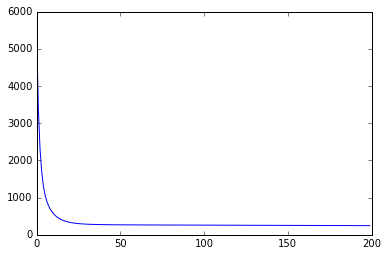

In [17]:
plt.plot(L)

In [ ]:
def calRMSE(result, oracle):
    return np.sum((result - oracle.values) ** 2)

In [ ]:
X_oracle = pd.read_csv("../dat/wine_quality/wine_zeroone_oracle.csv",header=None)
calRMSE(res, X_oracle)

In [ ]:
calRMSE(res, X_oracle)

In [ ]:
res.shape

In [18]:
sum(M.predict(tt_X) == tt_Y)/len(tt_Y)

0.60195828011919961

In [ ]:
tt_Y.shape